In [72]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import matplotlib
import pandas as pd

In [15]:
selected = sorted([x for x in os.listdir("../") if x.startswith("log")])[-1]
selected

'logs-STM32L4R9'

In [126]:
selected = "logs-STM32L4R9"

In [127]:
file = f"../{selected}/time_sync.json"
with open(file, "r") as f:
    time_sync = json.load(f)

In [128]:
file = f"../{selected}/ppk2_recording.csv"
data = pd.read_csv(file)
data["time"] = data["Timestamp(ms)"]
data["current"] = data["Current(uA)"]
data = data[data.current<1e5]

In [129]:
time_0 = time_sync[0]["start_time"]
time_sync_df = pd.DataFrame(time_sync)
time_sync_df["start_time"] -= time_0
time_sync_df["stop_time"] -= time_0
time_sync_df["start_time_ms"] = time_sync_df["start_time"]*1000
time_sync_df["stop_time_ms"] = time_sync_df["stop_time"]*1000

In [130]:
time_sync_df

,phase,start_time,stop_time,start_time_ms,stop_time_ms
0,prepare_for_inference,0.000000,3.185230,0.000000,3185.229778
1,generate_inference_code,3.185769,30.053729,3185.768843,30053.729057
2,deploy_model,30.062582,30.062603,30062.582016,30062.602997
3,deploy_code,30.067047,59.079313,30067.046881,59079.312801
4,prepare_data,59.084139,59.084159,59084.139109,59084.158897
5,transfer_data_to_memory,59.090963,59.097010,59090.962887,59097.009897
6,run_inference,59.099830,61.008126,59099.829912,61008.126020
7,read_inference_results,61.011116,61.011177,61011.116028,61011.177063
8,transfer_data_to_memory,61.013875,61.013885,61013.875008,61013.885021
9,run_inference,61.017064,62.891090,61017.063856,62891.089916


In [131]:
df = time_sync_df.groupby("phase").agg("mean").reset_index()
df["duration"] = df.stop_time_ms - df.start_time_ms
df[["phase","duration"]]

,phase,duration
0,deploy_code,29012.265921
1,deploy_model,0.020981
2,generate_inference_code,26867.960215
3,prepare_data,0.019789
4,prepare_for_inference,3185.229778
5,read_inference_results,0.021577
6,run_inference,1882.998168
7,transfer_data_to_memory,1.518786


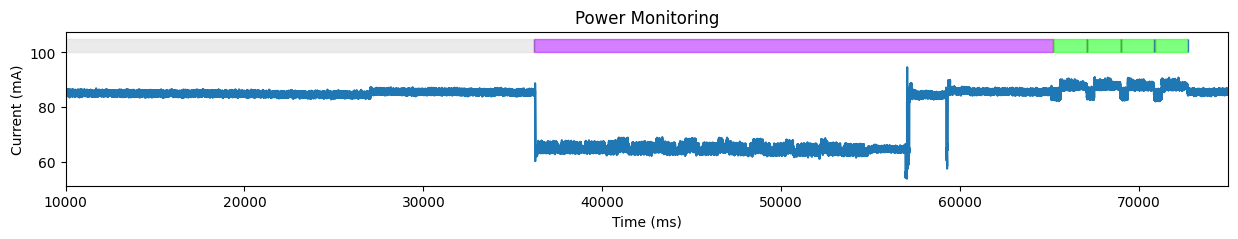

In [132]:
# plot signal
shift = 6100
fig = plt.figure(figsize=(15,2))
ax = fig.add_subplot(111) 
ax.plot(data.time.values, data.current.values/1000)
#plt.vlines(shift+time_sync_df.start_time_ms, ymin=50, ymax=100, color="r")

colors = {
    "prepare_for_inference":"#C8C8C8",
    "generate_inference_code":"#D8D8D8",
    "deploy_model": "#22FF00",
    "deploy_code":"#AA00FF",
    "prepare_data": "#C9C9C9",
    "transfer_data_to_memory":"#FF0000",
    "run_inference":"#00FF00",
    "read_inference_results":"#0000FF"}

for i, s in time_sync_df.iterrows():
    rect1 = matplotlib.patches.Rectangle((s.start_time_ms+shift, 100),
                                        s.stop_time_ms-s.start_time_ms, 5, 
                                
                                     color=colors[s.phase], alpha=0.5) 
    ax.add_patch(rect1) 

plt.ylabel("Current (mA)")
plt.xlabel("Time (ms)")
plt.title("Power Monitoring")
plt.xlim(10000,75000)
plt.show()

In [133]:
phase_colors = {"prepare_for_inference": "#A8A8A8",
                "generate_inference_code":"#FFD8D8",
                "deploy_model": "#00FFFF",
                "deploy_code":"#0000FF",
                "prepare_data": "#C8C8C8",
                "transfer_data_to_memory": "#FF8888",
                "run_inference": "#FF0000", 
                "read_inference_results": "#00FF00"}

figure = plt.figure(figsize=(20,2))
all_samples = []
#last_time = data[0]["start_timestamp"]
for phase in data:
    
    samples = np.asarray(phase["samples"])/1000
    #samples = samples[samples<100]
    if len(samples)==0:
        continue
        
    t_in = phase["start_timestamp"]
    t_ou = phase["stop_timestamp"]
    delta = (t_ou-t_in)/len(samples)
    times = np.arange(t_in, t_ou, delta)[:len(samples)]
    last_time = t_ou
    
    plt.plot(times, samples, "-", markersize=2, label=phase["phase"], color=phase_colors[phase["phase"]])
plt.legend(["Transfer Data", "Inference","Read"])
plt.legend()
plt.show()

TypeError: string indices must be integers

<Figure size 2000x200 with 0 Axes>

In [20]:
for phase in data:
    print(phase["phase"], np.max(phase["samples"])/1000)

transfer_data_to_memory 71.5116734052057
run_inference 73.73137016600407
read_inference_results 72.25144303033383
transfer_data_to_memory 70.03252204036342
run_inference 75.21181448222627
read_inference_results 72.99134195059996
transfer_data_to_memory 73.73137016600407
run_inference 75.21181448222627
read_inference_results 72.25144303033383
transfer_data_to_memory 71.5116734052057
run_inference 75.21181448222627
read_inference_results 72.25144303033383


In [269]:
data

[{'phase': 'deploy_model',
  'samples': [],
  'digital': [],
  'start_timestamp': 1705323404.7248719,
  'stop_timestamp': 1705323404.724915},
 {'phase': 'deploy_code',
  'samples': [],
  'digital': [],
  'start_timestamp': 1705323405.831202,
  'stop_timestamp': 1705323423.603169},
 {'phase': 'transfer_data_to_memory',
  'samples': [],
  'digital': [],
  'start_timestamp': 1705323424.7126532,
  'stop_timestamp': 1705323424.715372},
 {'phase': 'run_inference',
  'samples': [],
  'digital': [],
  'start_timestamp': 1705323425.849858,
  'stop_timestamp': 1705323425.9697878},
 {'phase': 'read_inference_results',
  'samples': [],
  'digital': [],
  'start_timestamp': 1705323427.084418,
  'stop_timestamp': 1705323427.0845451},
 {'phase': 'transfer_data_to_memory',
  'samples': [],
  'digital': [],
  'start_timestamp': 1705323428.194885,
  'stop_timestamp': 1705323428.194904},
 {'phase': 'run_inference',
  'samples': [],
  'digital': [],
  'start_timestamp': 1705323429.3361971,
  'stop_timesta

In [86]:
a[300000:]

[7248292.270343403,
 8903542.506026765,
 10694368.520325486,
 12620770.313239556,
 14682747.884768983,
 16880301.234913763,
 19213430.363673892,
 21682135.271049388,
 24286415.957040228,
 27026272.42164642,
 163882.20716566202,
 1005677.7711569007,
 1983049.1137634933,
 3095996.2349854405,
 4344519.134822739,
 5728617.813275394,
 7248292.270343403,
 8903542.506026765,
 10694368.520325486,
 12620770.313239556,
 14682747.884768983,
 16880301.234913763,
 19213430.363673892,
 21682135.271049388,
 24286415.957040228,
 27026272.42164642,
 163882.20716566202,
 1005677.7711569007,
 1983049.1137634933,
 3095996.2349854405,
 4344519.134822739,
 5728617.813275394,
 7248292.270343403,
 8903542.506026765,
 10694368.520325486,
 12620770.313239556,
 14682747.884768983,
 16880301.234913763,
 19213430.363673892,
 21682135.271049388,
 24286415.957040228,
 27026272.42164642,
 163882.20716566202,
 1005677.7711569007,
 1983049.1137634933,
 3095996.2349854405,
 4344519.134822739,
 5728617.813275394,
 724829